The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


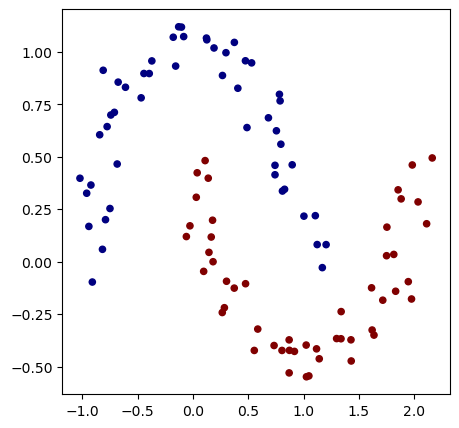

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
import random
from shrimpgrad import Tensor, nn, dtypes

np.random.seed(1337)
random.seed(1337)
# make up a dataset

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)
X = X.astype(float)
y = y.astype(float)
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')


In [21]:
X_train = Tensor.fromlist(X.shape, X.flatten().tolist())
y_train = Tensor.fromlist((100,1), y.flatten().tolist())
class Model:
    def __init__(self):
        self.layers: List[Callable[[Tensor], Tensor]] = [
         nn.Linear(2, 50), Tensor.relu,
         nn.Linear(50, 1), Tensor.sigmoid,
        ]
    def __call__(self, x: Tensor):
        return x.sequential(self.layers)


In [22]:
def get_parameters(model):
    params = []
    for layer in model.layers:
        if getattr(layer, 'parameters', None):
            params+=layer.parameters()
    return params
def optimize(model, x_train, target, epochs=1000, lr=0.01):
    epsilon = 1e-10
    out = None
    params = get_parameters(model)
    for epoch in range(epochs):
        for p in params: p.grad = None
        out = model(x_train)
        loss = out.binary_cross_entropy(target)
        loss.realize()
        numerator = ((target > 0).realize().data() == (out.data() > 0.5)).sum()
        accuracy = (numerator / out.size(0)) * 100.0
        loss.backward()
        loss.grad.realize()
        print(f'epoch={epoch} loss={loss.data()} acc={accuracy}')
        lr = 3.0 - 0.9*epoch/epochs
        for param in params:
            delta_p = param - (param.grad*lr)
            delta_p.realize()
            param.thunk.base.buff = delta_p.thunk.base.buff
    return model
optimize(model:=Model(), X_train, y_train, epochs=70, lr=0.1)

epoch=0 loss=0.6954397583007812 acc=0.0
epoch=1 loss=0.38499446868896486 acc=53.0
epoch=2 loss=0.33110469818115235 acc=50.0
epoch=3 loss=0.3038179016113281 acc=50.0
epoch=4 loss=0.28864906311035154 acc=51.0
epoch=5 loss=0.2789986228942871 acc=52.0
epoch=6 loss=0.27239973068237305 acc=52.0
epoch=7 loss=0.26741703033447267 acc=51.0
epoch=8 loss=0.2632095718383789 acc=51.0
epoch=9 loss=0.25951547622680665 acc=50.0
epoch=10 loss=0.2560277557373047 acc=50.0
epoch=11 loss=0.2527460479736328 acc=49.0
epoch=12 loss=0.24953269958496094 acc=49.0
epoch=13 loss=0.24639217376708986 acc=49.0
epoch=14 loss=0.2432866096496582 acc=49.0
epoch=15 loss=0.24017017364501952 acc=49.0
epoch=16 loss=0.23720335006713866 acc=49.0
epoch=17 loss=0.23390522003173828 acc=49.0
epoch=18 loss=0.23065952301025391 acc=49.0
epoch=19 loss=0.22737863540649414 acc=49.0
epoch=20 loss=0.22402353286743165 acc=49.0
epoch=21 loss=0.22071109771728514 acc=49.0
epoch=22 loss=0.2174469757080078 acc=49.0
epoch=23 loss=0.21385610580444

In [33]:
numerator = ((y_train > 0).realize().data() == (model(X_train) > 0.5)).sum()
numerator
(y_train > 0.0).realize().data()
(y_train.realize().data())

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],

(-1.548639298268643, 1.951360701731357)

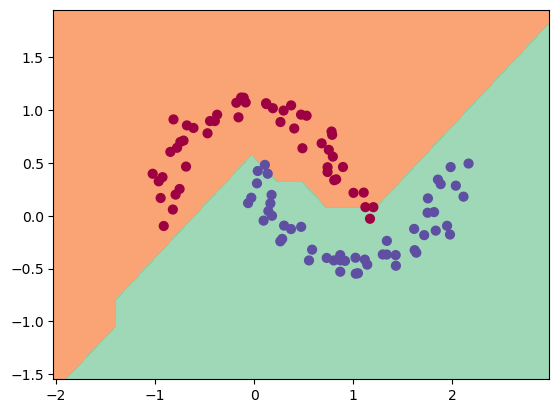

In [30]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
input_ = Tensor.fromlist(Xmesh.shape, data=Xmesh.flatten().tolist())
scores = model(input_)
scores.realize()
Z = np.array([s > 0.5 for s in scores.data()])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
